In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

import sys
from IPython.display import clear_output

%run utils/feature-extractor/feat_extraction.py
%run utils/utils_data_cleaning.py
%run utils/utils_line_supercover.py

### Load data

In [2]:
dataset = pkl.load(open('../data/dataset_10M.pkl', 'rb'))
dataset.head()

,index,pu_t,do_t,trip_dist,pu_lon,pu_lat,do_lon,do_lat,duration,vec_dist,trip_ratio
0,0,2016-02-16 19:56:06,2016-02-16 20:10:46,8.53,-73.995750,40.764488,-73.926292,40.867458,880,7.983998,1.068387
1,1,2016-02-11 10:23:41,2016-02-11 10:45:04,1.95,-73.994110,40.751068,-73.993401,40.736019,1283,1.039087,1.876648
2,2,2016-02-21 14:21:57,2016-02-21 14:30:07,0.50,-73.973160,40.752728,-73.982178,40.756962,490,0.556130,0.899070
3,3,2016-02-11 22:51:59,2016-02-11 22:57:41,1.30,-73.991280,40.744808,-73.985909,40.731178,342,0.981839,1.324045
4,4,2016-02-13 18:32:08,2016-02-13 18:43:51,1.50,-73.992897,40.741280,-73.975967,40.748734,703,1.026608,1.461123


In [3]:
# Output 
output = dataset[['trip_dist']]
output.head()

,trip_dist
0,8.53
1,1.95
2,0.50
3,1.30
4,1.50


### 1. Linear Model

#### Extract feature

In [4]:
# Instantiate a (concrete) component
featExtractor = FeatureExtractor(dataset=dataset)

# Decorate with features
featExtractor = VectorDistanceFeature(featExtractor)

# Extract them
features = featExtractor.getFeatures()
features.head()

Extracting VectorDistance Features...


,vec_dist
0,7.983998
1,1.039087
2,0.556130
3,0.981839
4,1.026608


#### Train/Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(np.array(features), np.array(output), test_size=0.3, random_state=42)

test_size = len(y_test)
train_size = len(y_train)
print('Train size =', train_size)
print('Test size =', test_size)

Train size = 7000000
Test size = 3000000


#### Train

In [6]:
linear_model = np.median(y_train / X_train)
linear_model

1.3090175661026477

#### Test and Evaluate

In [7]:
y_pred = linear_model * X_test
print('RMSE =', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

mean_relative_deviation = np.mean(np.abs(y_pred - y_test)/y_test)
print('Mean Relative Deviation = {0:.2f}%'.format(mean_relative_deviation * 100))

RMSE = 0.9221532900606446
Mean Relative Deviation = 15.34%


### 2. Grid-based Model

#### Extract feature

In [8]:
# Instantiate a (concrete) component
featExtractor = FeatureExtractor(dataset=dataset)

# Decorate with features
featExtractor = CoordinatesFeature(featExtractor)
featExtractor = VectorDistanceFeature(featExtractor)
featExtractor = TripDistanceRatioFeature(featExtractor)

# Extract them
features = featExtractor.getFeatures()
features.head()

Extracting Coordinates Features...
Extracting VectorDistance Features...
Extracting TripDistanceRatio Features...


,pu_lon,pu_lat,do_lon,do_lat,vec_dist,trip_ratio
0,-73.995750,40.764488,-73.926292,40.867458,7.983998,1.068387
1,-73.994110,40.751068,-73.993401,40.736019,1.039087,1.876648
2,-73.973160,40.752728,-73.982178,40.756962,0.556130,0.899070
3,-73.991280,40.744808,-73.985909,40.731178,0.981839,1.324045
4,-73.992897,40.741280,-73.975967,40.748734,1.026608,1.461123


#### Train/Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, output, test_size=0.3, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)

y_test = np.array(y_test.trip_dist)

test_size = len(y_test)
train_size = len(y_train)
print('Train size =', train_size)
print('Test size =', test_size)

Train size = 7000000
Test size = 3000000


#### Instantiate grids

In [10]:
%run utils/utils_line_supercover.py
sizes = [20, 40, 100, 150, 200, 300]
region = (LAT_NORTH, LAT_SOUTH, LON_EAST, LON_WEST)

gMaps = []
median_maps = []

gMaps = [GridMap(size=(s,s), bbox=region) for s in sizes]

#### Fit to data

In [11]:
median_maps = [gMap.fitGrid(X_train, func='median') for gMap in gMaps]

Started fitting grid of size 20x20
Normalizing data...
Building assigning map...
Time spent: 214.98803471722084
Reducing map...
Finished.

Started fitting grid of size 40x40
Normalizing data...
Building assigning map...
Time spent: 244.0797511216049
Reducing map...
Finished.

Started fitting grid of size 100x100
Normalizing data...
Building assigning map...
Time spent: 351.83148321321966
Reducing map...
Finished.

Started fitting grid of size 150x150
Normalizing data...
Building assigning map...
Time spent: 429.751751981355
Reducing map...
Finished.

Started fitting grid of size 200x200
Normalizing data...
Building assigning map...
Time spent: 516.1457648487337
Reducing map...
Finished.

Started fitting grid of size 300x300
Normalizing data...
Building assigning map...
Time spent: 682.256936627117
Reducing map...
Finished.



#### Dump models

In [18]:
for i, size in enumerate(sizes):
    pkl.dump(gMaps[i], open('../distance_models/grid_trip_distance_model_{0}.mdl'.format(size), 'wb'))

#### Prediction

In [19]:
y_pred = [np.array(gMap.predictFactor(X_test)) * X_test[:,-2] for gMap in gMaps]

Started prediction on grid of size 20x20
Normalizing data...
Prediction has started.
Finished.

Started prediction on grid of size 40x40
Normalizing data...
Prediction has started.
Finished.

Started prediction on grid of size 100x100
Normalizing data...
Prediction has started.
Finished.

Started prediction on grid of size 150x150
Normalizing data...
Prediction has started.
Finished.

Started prediction on grid of size 200x200
Normalizing data...
Prediction has started.
Finished.

Started prediction on grid of size 300x300
Normalizing data...
Prediction has started.
Finished.



In [20]:
for i in range(len(sizes)):
    mean_relative_deviation = np.mean(np.abs(y_pred[i] - y_test)/y_test)
    print('Size {0}: RMSE = {1}'.format(sizes[i], np.sqrt(metrics.mean_squared_error(y_test, y_pred[i]))))
    print('Size {0}: Mean Relative Deviation = {1:.2f}%'.format(sizes[i], mean_relative_deviation * 100))
    print()

Size 20: RMSE = 0.8063359144503112
Size 20: Mean Relative Deviation = 14.86%

Size 40: RMSE = 0.7861908750722753
Size 40: Mean Relative Deviation = 14.68%

Size 100: RMSE = 0.7710428675236605
Size 100: Mean Relative Deviation = 14.40%

Size 150: RMSE = 0.7682078981788114
Size 150: Mean Relative Deviation = 14.32%

Size 200: RMSE = 0.7668762595485951
Size 200: Mean Relative Deviation = 14.28%

Size 300: RMSE = 0.7656540017370421
Size 300: Mean Relative Deviation = 14.24%



In [31]:
mdl = pkl.load(open('../distance_models/grid_trip_distance_model_300.mdl', 'rb')).grid_model

clipped_mdl = mdl.copy()

In [35]:
clipped_mdl[clipped_mdl > 4] = 4

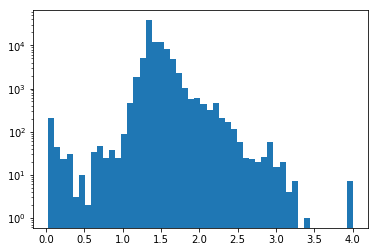

In [38]:
clipped_mdl_vec  =  clipped_mdl[~np.isnan( clipped_mdl)]

plt.hist(clipped_mdl_vec, bins=50, log=True)
plt.show()

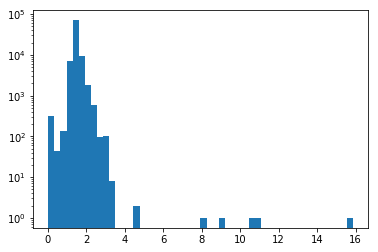

In [37]:
mdl_vec  =  mdl[~np.isnan( mdl)]

plt.hist(mdl_vec, bins=50, log=True)
plt.show()